### SAM Model:


*   Trained on 11 billion segmentation masks from different types of images
*   During training and inference, the input of the model takes both an image along with a prompt. The prompt can be in the form of bounding boxes over the region of interest, points of interest, or text input that is embedded as an input


### SAM features


*   Segments objects it has never seen before, known as **zero-shot generalization**

*   3 different types of prompts that allows model

*   Real time applications, since it detects very quickly
*   Ambiguity Awareness: can detect objects/generate masks that are overlapping with other objects

### SAM Model


*   Takes 2 inputs: prompt and image


*   Model contains 3 parts, prompt decodder, image encoder, and lightweight mask decoder

*   Image fed into image decoder, prompts fed into prompt decoder
*  Resulting embeddings combined and fed into light weight mask decoder  

*   Resulting output is a mask with a score


*   Image encoder is a vision transformer (ViT-H)
*   Prompt Encoder is a simple text encoder that converts prompt into vector representation


*   Lightweight mask decoder is a light weight transformer model that uses embeddings from inputs to predict mask
*   Fine tuning the SAM model typically invovles freezing the prompt and image encoders and training the mask decoder on our data, masks, and prompts

### Why are prompts needed as compared to regular with just images and masks?



*   SAM model shows a much higher probabilities in the probability map when using the prompts compared to just the image
*   

Dependencies

In [ ]:
# Install the required libraries
#SAM
!pip install git+https://github.com/facebookresearch/segment-anything.git
#Transformers
!pip install -q git+https://github.com/huggingface/transformers.git
#Datasets to prepare data and monai if you want to use special loss functions
!pip install datasets
!pip install -q monai
#Patchify to divide large images into smaller patches for training. (Not necessary for smaller images)
!pip install patchify

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-43ub8rbi
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-43ub8rbi
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36590 sha256=72c3a1dd6853f3bd2f7bfc754485becdb60c3f6196b53657f91427ee92680fc4
  Stored in directory: /tmp/pip-ephem-wheel-cache-36wxqk2f/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tifffile
import os
from patchify import patchify  #Only to handle large images
import random
from scipy import ndimage

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tifffile
import os
from patchify import patchify  #Only to handle large images
import random
from scipy import ndimage

Mask of Image 1

In [ ]:
# Error Checking
from PIL import Image

# Define the file path
file_path = '/content/masked_wsi_gt2.png'

# Check if the file exists
from pathlib import Path

if Path(file_path).exists():
    print(f"The file {file_path} exists.")

    # Open the image file
    image = Image.open(file_path)

    # Display the image
    image.show()

    # Print image details
    print(f"Image format: {image.format}")
    print(f"Image size: {image.size}")
    print(f"Image mode: {image.mode}")

    # Optionally, convert to a different mode (e.g., grayscale)
    grayscale_image = image.convert('L')
    grayscale_image.show()
    print(f"Grayscale image mode: {grayscale_image.mode}")

else:
    print(f"The file {file_path} does not exist.")


The file /content/masked_wsi_gt2.png exists.
Image format: PNG
Image size: (2800, 2800)
Image mode: RGBA
Grayscale image mode: L


In [ ]:
a=np.array(grayscale_image)
np.unique(a)

array([ 30, 215], dtype=uint8)

Mask of Image 2

In [ ]:
from PIL import Image

# Define the file path
file_path = '/content/masked_wsi_gt1.png'

# Check if the file exists
from pathlib import Path

if Path(file_path).exists():
    print(f"The file {file_path} exists.")

    # Open the image file
    image = Image.open(file_path)

    # Display the image
    image.show()

    # Print image details
    print(f"Image format: {image.format}")
    print(f"Image size: {image.size}")
    print(f"Image mode: {image.mode}")

    # Optionally, convert to a different mode (e.g., grayscale)
    grayscale_image = image.convert('L')
    grayscale_image.show()
    print(f"Grayscale image mode: {grayscale_image.mode}")

else:
    print(f"The file {file_path} does not exist.")

The file /content/masked_wsi_gt1.png exists.
Image format: PNG
Image size: (2800, 2800)
Image mode: RGBA
Grayscale image mode: L


In [ ]:
b=np.array(grayscale_image)
np.unique(b)

array([ 30, 215], dtype=uint8)

Checking if masks are truly binary

In [ ]:
a[a == 30] = 0
a[a == 215] = 255
np.unique(a)

array([  0, 255], dtype=uint8)

In [ ]:
b[b == 30] = 0
b[b == 215] = 255
np.unique(b)

array([  0, 255], dtype=uint8)

In [ ]:
mask_pngs=np.array([b,a])
mask_pngs.shape
np.unique(mask_pngs)

array([  0, 255], dtype=uint8)

Loading Images as TIFF files

In [ ]:
import os
import numpy as np
from PIL import Image

def read_tif_files_to_numpy(directory_path):
    # List to store the numpy arrays
    images_as_arrays = []

    # Ensure the directory exists
    if os.path.exists(directory_path) and os.path.isdir(directory_path):
        # List all files in the directory
        for filename in os.listdir(directory_path):
            if filename.endswith('.tif') or filename.endswith('.tiff'):
                # Full path to the file
                file_path = os.path.join(directory_path, filename)

                # Open the image file
                with Image.open(file_path) as img:
                    # Convert the image to a numpy array
                    img_array = np.array(img)
                    # Append the numpy array to the list
                    images_as_arrays.append(img_array)
    else:
        print(f"The directory {directory_path} does not exist.")

    return images_as_arrays

# Specify the directory containing the TIFF files
directory_path = '/content/drive/MyDrive/qupath/images'

# Read the TIFF files and convert them to numpy arrays
tif_arrays = read_tif_files_to_numpy(directory_path)

# Print the shapes of the numpy arrays
for i, array in enumerate(tif_arrays):
    print(f"Image {i+1} shape: {array.shape}")


Image 1 shape: (2800, 2800, 3)
Image 2 shape: (2800, 2800, 3)


In [ ]:
tifstack=np.array(tif_arrays)

In [ ]:
tifstack.shape

(2, 2800, 2800, 3)

In [ ]:
mask_pngs.shape

(2, 2800, 2800)

Use Patchify Library to extract into Patches

In [ ]:
patch_size = 256
step = 256

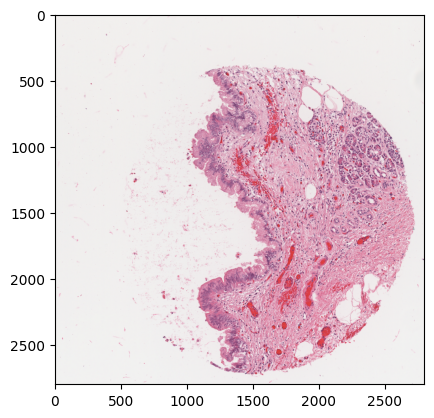

In [ ]:
plt.imshow(tifstack[1] , cmap='gray')

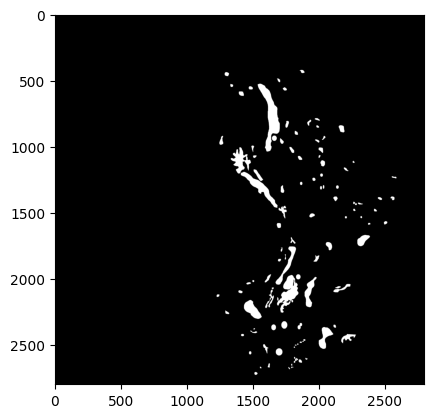

In [ ]:
plt.imshow(mask_pngs[1] , cmap='gray')

In [ ]:
large_masks=mask_pngs.copy()
large_images=tifstack.copy()

In [ ]:
large_masks.shape

(2, 2800, 2800)

In [ ]:
large_masks.shape[2]

2800

In [ ]:
new_height = (large_masks.shape[1] // 256 + 1) * 256
new_width = (large_masks.shape[2] // 256 + 1) * 256
print(new_height)
print(new_width)

2816
2816


In [ ]:
large_images.shape

(2, 2800, 2800, 3)

In [ ]:
large_images[0].shape

(2800, 2800, 3)

In [ ]:
large_images_new=[]
large_masks_new=[]
for idx in range(large_masks.shape[0]):
  resized_image=Image.fromarray(large_images[idx]).resize((new_width, new_height), Image.ANTIALIAS)
  resized_image_array = np.array(resized_image)
  large_images_new.append(resized_image_array)

  resized_mask=Image.fromarray(large_masks[idx]).resize((new_width, new_height), Image.NEAREST)
  resized_mask_array = np.array(resized_mask)
  large_masks_new.append(resized_mask_array)

large_images=np.array(large_images_new)
large_masks=np.array(large_masks_new)


<ipython-input-25-4479585cfc45>:4: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resized_image=Image.fromarray(large_images[idx]).resize((new_width, new_height), Image.ANTIALIAS)


In [ ]:
large_images.shape

(2, 2816, 2816, 3)

In [ ]:
large_masks.shape

(2, 2816, 2816)

In [ ]:
np.unique(large_masks)

array([  0, 255], dtype=uint8)

In [ ]:
all_img_patches = []
image_patches=[]
mask_patches=[]
for img in range(large_images.shape[0]):
    large_image = large_images[img]
    patches_img = patchify(large_image, (patch_size, patch_size,3), step=step)  #Step=256 for 256 patches means no overlap

    for i in range(patches_img.shape[0]):
        for j in range(patches_img.shape[1]):
            image_patches.append([img,i,j])

            # Indexing the patch
            single_patch_img = patches_img[i,j,:,:]
            all_img_patches.append(single_patch_img)

images_new = np.array(all_img_patches)

#Let us do the same for masks
all_mask_patches = []
for img in range(large_masks.shape[0]):
    large_mask = large_masks[img]
    patches_mask = patchify(large_mask, (patch_size, patch_size), step=step)  #Step=256 for 256 patches means no overlap

    for i in range(patches_mask.shape[0]):
        for j in range(patches_mask.shape[1]):
            mask_patches.append([img,i,j])

            single_patch_mask = patches_mask[i,j,:,:]
            single_patch_mask = (single_patch_mask / 255.).astype(np.uint8)
            all_mask_patches.append(single_patch_mask)

masks_new = np.array(all_mask_patches)

In [ ]:
large_image.shape

(2816, 2816, 3)

In [ ]:
patches_img.shape

(11, 11, 1, 256, 256, 3)

In [ ]:
single_patch_img.shape

(1, 256, 256, 3)

In [ ]:
print(images_new.shape)
print(masks_new.shape)

(242, 1, 256, 256, 3)
(242, 256, 256)


In [ ]:
images_new=np.squeeze(images_new,axis=1)
images_new.shape

(242, 256, 256, 3)

In [ ]:
from datasets import Dataset
from PIL import Image

# Convert the NumPy arrays to Pillow images and store them in a dictionary
dataset_dict = {
    "image": [Image.fromarray(img) for img in images_new],
    "label": [Image.fromarray(mask) for mask in masks_new],
}

# Create the dataset using the datasets.Dataset class
dataset_new = Dataset.from_dict(dataset_dict)

In [ ]:
len(image_patches)

242

In [ ]:
len(mask_patches)

242

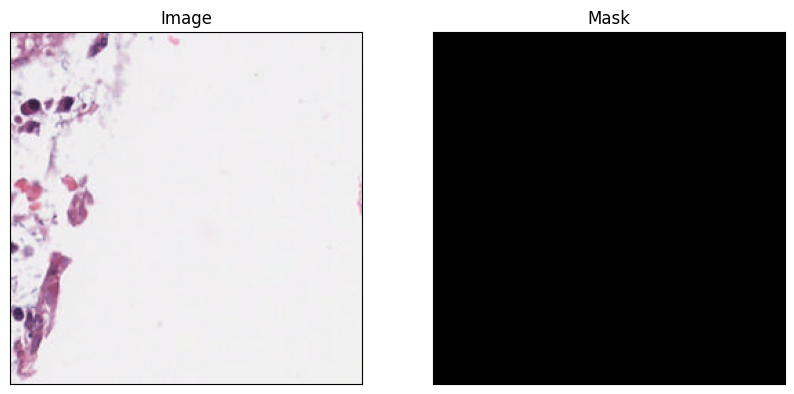

In [ ]:
img_num = random.randint(0, images_new.shape[0]-1)
example_image = dataset_new[img_num]["image"]
example_mask = dataset_new[img_num]["label"]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first image on the left
axes[0].imshow(np.array(example_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(example_mask, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

Get rid of the masks with all 0's

In [ ]:
image_patches[1:2]

[[0, 0, 1]]

In [ ]:
image_patches=np.array(image_patches)
mask_patches=np.array(mask_patches)

In [ ]:
# Create a list to store the indices of non-empty masks
valid_indices = [i for i, mask in enumerate(masks_new) if mask.max() != 0]
# Filter the image and mask arrays to keep only the non-empty pairs
filtered_images = images_new[valid_indices]
filtered_masks = masks_new[valid_indices]
filtered_mask_patches = mask_patches[valid_indices]
print("Image shape:", filtered_images.shape)  # e.g., (num_frames, height, width, num_channels)
print("Mask shape:", filtered_masks.shape)

Image shape: (73, 256, 256, 3)
Mask shape: (73, 256, 256)


In [ ]:
filtered_image_patches=image_patches[valid_indices]

In [ ]:
filtered_image_patches.shape

(73, 3)

In [ ]:
filtered_mask_patches.shape

(73, 3)

Left with only 73 patches

In [ ]:
from datasets import Dataset
from PIL import Image

# Convert the NumPy arrays to Pillow images and store them in a dictionary
dataset_dict = {
    "image": [Image.fromarray(img) for img in filtered_images],
    "label": [Image.fromarray(mask) for mask in filtered_masks],
}

# Create the dataset using the datasets.Dataset class
dataset = Dataset.from_dict(dataset_dict)

In [ ]:
dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 73
})

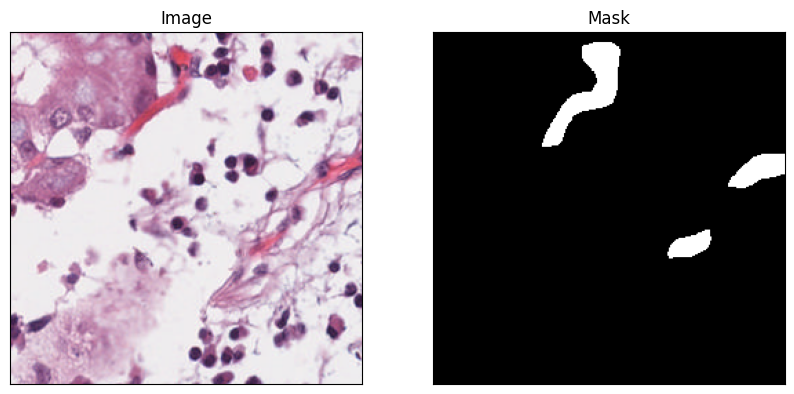

In [ ]:
img_num = random.randint(0, filtered_images.shape[0]-1)
example_image = dataset[img_num]["image"]
example_mask = dataset[img_num]["label"]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first image on the left
axes[0].imshow(np.array(example_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(example_mask, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

### Bounding Boxes

In [ ]:
#Get bounding boxes from mask.
def get_bounding_box(ground_truth_map):
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

In [ ]:
print(images_new.shape)
masks_new.shape

(242, 256, 256, 3)


(242, 256, 256)

Custom Dataset class

In [ ]:
from torch.utils.data import Dataset

class SAMDataset(Dataset):
  """
  This class is used to create a dataset that serves input images and masks.
  It takes a dataset and a processor as input and overrides the __len__ and __getitem__ methods of the Dataset class.
  """
  def __init__(self, dataset, processor):
    self.dataset = dataset
    self.processor = processor

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    item = self.dataset[idx]
    image = item["image"]
    #image=image.convert('RGB')
    ground_truth_mask = np.array(item["label"])

    # get bounding box prompt
    prompt = get_bounding_box(ground_truth_mask)

    # prepare image and prompt for the model
    inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")

    # remove batch dimension which the processor adds by default
    inputs = {k:v.squeeze(0) for k,v in inputs.items()}

    # add ground truth segmentation
    inputs["ground_truth_mask"] = ground_truth_mask

    return inputs

In [ ]:
# Initialize the processor
from transformers import SamProcessor
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

In [ ]:
train_dataset = SAMDataset(dataset=dataset, processor=processor)

In [ ]:
np.unique(filtered_masks)

array([0, 1], dtype=uint8)

In [ ]:
example = train_dataset[0]
for k,v in example.items():
  print(k,v.shape)

pixel_values torch.Size([3, 1024, 1024])
original_sizes torch.Size([2])
reshaped_input_sizes torch.Size([2])
input_boxes torch.Size([1, 4])
ground_truth_mask (256, 256)


Dataloader

In [ ]:
# Create a DataLoader instance for the training dataset
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, drop_last=False)

In [ ]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k,v.shape)

pixel_values torch.Size([2, 3, 1024, 1024])
original_sizes torch.Size([2, 2])
reshaped_input_sizes torch.Size([2, 2])
input_boxes torch.Size([2, 1, 4])
ground_truth_mask torch.Size([2, 256, 256])


In [ ]:
batch["ground_truth_mask"].shape

torch.Size([2, 256, 256])

Only training lightweight mask decoder

In [ ]:
# Load the model
from transformers import SamModel
model = SamModel.from_pretrained("facebook/sam-vit-base")

# make sure we only compute gradients for mask decoder
for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)

In [ ]:
from torch.optim import Adam
import monai
# Initialize the optimizer and the loss function
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)
#Try DiceFocalLoss, FocalLoss, DiceCELoss
seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

Training

In [ ]:
from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize

#Training loop
num_epochs = 10

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()
for epoch in range(num_epochs):
    epoch_losses = []
    for batch in tqdm(train_dataloader):
      # forward pass
      outputs = model(pixel_values=batch["pixel_values"].to(device),
                      input_boxes=batch["input_boxes"].to(device),
                      multimask_output=False)

      # compute loss
      predicted_masks = outputs.pred_masks.squeeze(1)
      ground_truth_masks = batch["ground_truth_mask"].float().to(device)
      loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

      # backward pass (compute gradients of parameters w.r.t. loss)
      optimizer.zero_grad()
      loss.backward()

      # optimize
      optimizer.step()
      epoch_losses.append(loss.item())

    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(epoch_losses)}')

100%|██████████| 37/37 [00:33<00:00,  1.12it/s]


EPOCH: 0
Mean loss: 0.8921380292724919


100%|██████████| 37/37 [00:33<00:00,  1.10it/s]


EPOCH: 1
Mean loss: 0.5988163480887542


100%|██████████| 37/37 [00:34<00:00,  1.06it/s]


EPOCH: 2
Mean loss: 0.5500707928393338


100%|██████████| 37/37 [00:38<00:00,  1.04s/it]


EPOCH: 3
Mean loss: 0.48890202754252665


100%|██████████| 37/37 [00:38<00:00,  1.04s/it]


EPOCH: 4
Mean loss: 0.46198399526041906


100%|██████████| 37/37 [00:38<00:00,  1.03s/it]


EPOCH: 5
Mean loss: 0.4388347686948003


100%|██████████| 37/37 [00:38<00:00,  1.04s/it]


EPOCH: 6
Mean loss: 0.4197667966017852


100%|██████████| 37/37 [00:37<00:00,  1.02s/it]


EPOCH: 7
Mean loss: 0.4004718097480568


100%|██████████| 37/37 [00:38<00:00,  1.03s/it]


EPOCH: 8
Mean loss: 0.38671659859451085


100%|██████████| 37/37 [00:38<00:00,  1.03s/it]

EPOCH: 9
Mean loss: 0.37830663412003906


In [ ]:
# Save the model's state dictionary to a file2
torch.save(model.state_dict(), "/content/drive/MyDrive/bloodvessels_checkpoint2_10epochs.pth")

In [ ]:
file_path = '/content/drive/MyDrive/bloodvessels_checkpoint2_10epochs.pth'

if os.path.exists(file_path):
    print(f"The file {file_path} exists.")
else:
    print(f"The file {file_path} does not exist.")


The file /content/drive/MyDrive/bloodvessels_checkpoint2_10epochs.pth exists.


Inference

In [ ]:
from transformers import SamModel, SamConfig, SamProcessor
import torch
# Load the model configuration
model_config = SamConfig.from_pretrained("facebook/sam-vit-base")
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

# Create an instance of the model architecture with the loaded configuration
bloodvessels_model = SamModel(config=model_config)
#Update the model by loading the weights from saved file.
bloodvessels_model.load_state_dict(torch.load("/content/drive/MyDrive/bloodvessels_checkpoint2_10epochs.pth"))

config.json:   0%|          | 0.00/6.57k [00:00<?, ?B/s]

<All keys matched successfully>

In [ ]:
# set the device to cuda if available, otherwise use cpu
device = "cuda" if torch.cuda.is_available() else "cpu"
bloodvessels_model.to(device)

SamModel(
  (shared_image_embedding): SamPositionalEmbedding()
  (vision_encoder): SamVisionEncoder(
    (patch_embed): SamPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (layers): ModuleList(
      (0-11): 12 x SamVisionLayer(
        (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionAttention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (layer_norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): SamMLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (neck): SamVisionNeck(
      (conv1): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (layer_norm1): SamLayerNorm()
     

In [ ]:
len(dataset)

73

In [ ]:
prob_preds=[]
mask_preds=[]
for idx in range(len(dataset)):
  test_image = dataset[idx]["image"]
  test_image_shape=np.array(test_image).shape
  #print(test_image_shape)

  test_image_shape_new=np.array(test_image).shape
  #print(test_image_shape_new)
  # get box prompt based on ground truth segmentation map
  ground_truth_mask = np.array(dataset[idx]["label"])
  prompt = get_bounding_box(ground_truth_mask)

  # prepare image + box prompt for the model
  inputs = processor(test_image, input_boxes=[[prompt]], return_tensors="pt")

  inputs = {k: v.to(device) for k, v in inputs.items()}

  bloodvessels_model.eval()

  # forward pass
  with torch.no_grad():
      outputs = bloodvessels_model(**inputs, multimask_output=False)

  # apply sigmoid
  medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
  medsam_seg_intermediate=outputs.pred_masks.squeeze(1)
  # convert soft mask to hard mask
  medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
  medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)

  prob_preds.append(medsam_seg_prob)
  mask_preds.append(medsam_seg)

prob_preds=np.array(prob_preds)
mask_preds=np.array(mask_preds)

print(prob_preds.shape)
print(mask_preds.shape)





(73, 256, 256)
(73, 256, 256)


In [ ]:
import numpy as np
import random
import torch
import matplotlib.pyplot as plt

# let's take a random training example
idx = random.randint(0, filtered_images.shape[0]-1)

# load image
test_image = dataset[idx]["image"]
test_image_shape=np.array(test_image).shape
print(test_image_shape)
#test_image=test_image.convert('RGB')
test_image_shape_new=np.array(test_image).shape
print(test_image_shape_new)
# get box prompt based on ground truth segmentation map
ground_truth_mask = np.array(dataset[idx]["label"])
prompt = get_bounding_box(ground_truth_mask)

# prepare image + box prompt for the model
inputs = processor(test_image, input_boxes=[[prompt]], return_tensors="pt")

(256, 256, 3)
(256, 256, 3)


In [ ]:
inputs = {k: v.to(device) for k, v in inputs.items()}

bloodvessels_model.eval()

# forward pass
with torch.no_grad():
    outputs = bloodvessels_model(**inputs, multimask_output=False)

# apply sigmoid
medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
medsam_seg_intermediate=outputs.pred_masks.squeeze(1)
# convert soft mask to hard mask
medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)

In [ ]:
medsam_seg.shape

(256, 256)

In [ ]:
medsam_seg_prob.shape

(256, 256)

In [ ]:
type(train_dataset[idx]['ground_truth_mask'])

numpy.ndarray

In [ ]:
type(medsam_seg)

numpy.ndarray

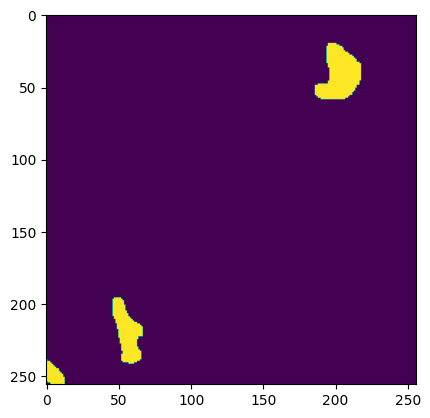

In [ ]:
plt.imshow(train_dataset[idx]['ground_truth_mask'])

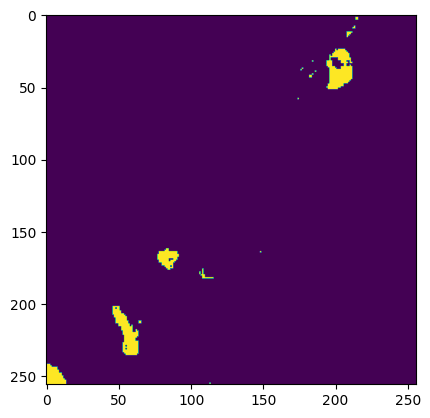

In [ ]:
plt.imshow(medsam_seg)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=uint8)
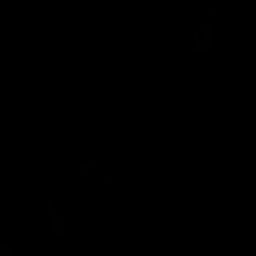

In [ ]:
medsam_seg

In [ ]:
import numpy as np

def dice_score(pred, gt, epsilon=1e-6):
    """
    Calculate the Dice Score between two binary masks.

    Args:
        pred (np.ndarray): Predicted binary mask (array of shape [H, W] or [N, H, W], dtype=uint8)
        gt (np.ndarray): Ground truth binary mask (array of shape [H, W] or [N, H, W], dtype=uint8)
        epsilon (float): Small value to avoid division by zero (default is 1e-6)

    Returns:
        float: Dice score
    """
    # Ensure the masks are binary and of type float32
    pred = pred.astype(np.float32)
    gt = gt.astype(np.float32)

    # Flatten the masks if they have a batch dimension
    if pred.ndim == 3:  # Batch of masks
        pred = pred.reshape(pred.shape[0], -1)
        gt = gt.reshape(gt.shape[0], -1)
    else:
        pred = pred.flatten()
        gt = gt.flatten()

    intersection = np.sum(pred * gt, axis=-1)
    union = np.sum(pred, axis=-1) + np.sum(gt, axis=-1)

    dice = (2. * intersection + epsilon) / (union + epsilon)
    return np.mean(dice)

# Example usage with single 256x256 binary masks
pred = np.random.randint(0, 2, (256, 256), dtype=np.uint8)
gt = np.random.randint(0, 2, (256, 256), dtype=np.uint8)

dice = dice_score(pred, gt)
print(f"Dice Score: {dice}")

# Example usage with a batch of 256x256 binary masks
pred_batch = np.random.randint(0, 2, (4, 256, 256), dtype=np.uint8)
gt_batch = np.random.randint(0, 2, (4, 256, 256), dtype=np.uint8)

dice_batch = dice_score(pred_batch, gt_batch)
print(f"Dice Score (Batch): {dice_batch}")


Dice Score: 0.5033598786575145
Dice Score (Batch): 0.49992284178733826


In [ ]:
gt=train_dataset[idx]['ground_truth_mask']

In [ ]:
gt.dtype

dtype('uint8')

In [ ]:
medsam_seg.dtype

dtype('uint8')

In [ ]:
dice_example=dice_score(medsam_seg,gt)
dice_example

0.609991942139407

In [ ]:
# Completely overlapping masks
pred = np.ones((256, 256), dtype=np.uint8)
gt = np.ones((256, 256), dtype=np.uint8)
dice = dice_score(pred, gt)
print(f"Dice Score (Perfect Overlap): {dice}")

Dice Score (Perfect Overlap): 1.0


In [ ]:
import numpy as np

def pixel_accuracy(pred, gt):
    """
    Calculate the pixel accuracy between two binary masks.

    Args:
        pred (np.ndarray): Predicted binary mask (array of shape [H, W] or [N, H, W], dtype=uint8)
        gt (np.ndarray): Ground truth binary mask (array of shape [H, W] or [N, H, W], dtype=uint8)

    Returns:
        float: Pixel accuracy
    """
    # Ensure the masks are of type uint8
    pred = pred.astype(np.uint8)
    gt = gt.astype(np.uint8)

    # Calculate the total number of pixels
    total_pixels = np.prod(gt.shape)

    # Calculate the number of correctly predicted pixels
    correct_pixels = np.sum(pred == gt)

    # Calculate pixel accuracy
    accuracy = correct_pixels / total_pixels
    return accuracy

# Example usage with single 256x256 binary masks
pred = np.random.randint(0, 2, (256, 256), dtype=np.uint8)
gt = np.random.randint(0, 2, (256, 256), dtype=np.uint8)

accuracy = pixel_accuracy(pred, gt)
print(f"Pixel Accuracy: {accuracy:.4f}")

# Example usage with a batch of 256x256 binary masks
pred_batch = np.random.randint(0, 2, (4, 256, 256), dtype=np.uint8)
gt_batch = np.random.randint(0, 2, (4, 256, 256), dtype=np.uint8)

accuracies = [pixel_accuracy(pred_batch[i], gt_batch[i]) for i in range(pred_batch.shape[0])]
print(f"Pixel Accuracies (Batch): {accuracies}")


Pixel Accuracy: 0.5021
Pixel Accuracies (Batch): [0.498138427734375, 0.50140380859375, 0.497467041015625, 0.500701904296875]


In [ ]:
acc=pixel_accuracy(medsam_seg,gt)
acc

0.9852294921875

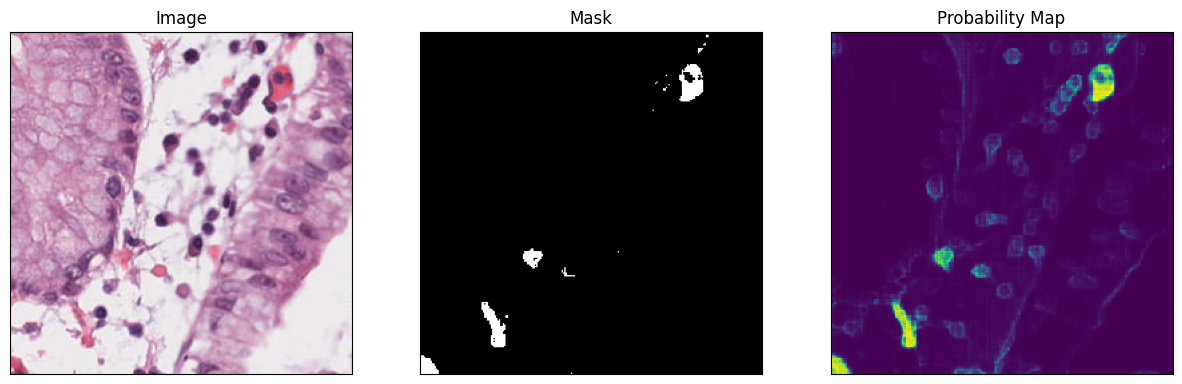

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot the first image on the left
axes[0].imshow(np.array(test_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(medsam_seg, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Plot the second image on the right
axes[2].imshow(medsam_seg_prob)  # Assuming the second image is grayscale
axes[2].set_title("Probability Map")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()


In [ ]:
ground_truth_masks=[]
for i in range(len(dataset)):
  ground_truth_masks.append(train_dataset[i]['ground_truth_mask'])

In [ ]:
len(ground_truth_masks)

73

In [ ]:
dice_scores=[]
accuracies=[]
for i in range(len(ground_truth_masks)):
  dice_scores.append(dice_score(mask_preds[i],ground_truth_masks[i]))
  accuracies.append(pixel_accuracy(mask_preds[i],ground_truth_masks[i]))

In [ ]:
np.array(dice_scores).mean()

0.6634743826193187

In [ ]:
np.array(accuracies).mean()

0.9702194422891696

In [ ]:
patches_mask.shape

(11, 11, 256, 256)

In [ ]:
masks_new.shape

(242, 256, 256)

In [ ]:
print(patches_mask[0,0,:,:])

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [ ]:
np.unique(patches_mask[0,0,:,:])

array([0], dtype=uint8)

In [ ]:
patches_mask[0,0,:,:].shape

(256, 256)

In [ ]:
filtered_mask_patches_list=filtered_mask_patches.tolist()
len(filtered_mask_patches_list)

73

In [ ]:
filtered_mask_patches_list[0]

[0, 2, 5]

In [ ]:
filtered_mask_patches_list

[[0, 2, 5],
 [0, 3, 2],
 [0, 3, 4],
 [0, 3, 5],
 [0, 4, 1],
 [0, 4, 2],
 [0, 4, 4],
 [0, 4, 5],
 [0, 4, 7],
 [0, 4, 8],
 [0, 5, 1],
 [0, 5, 2],
 [0, 5, 3],
 [0, 5, 4],
 [0, 5, 5],
 [0, 5, 7],
 [0, 5, 8],
 [0, 5, 9],
 [0, 5, 10],
 [0, 6, 1],
 [0, 6, 2],
 [0, 6, 3],
 [0, 6, 4],
 [0, 6, 5],
 [0, 6, 9],
 [0, 7, 1],
 [0, 7, 2],
 [0, 7, 3],
 [0, 7, 4],
 [0, 7, 6],
 [0, 8, 3],
 [0, 8, 4],
 [1, 1, 5],
 [1, 1, 6],
 [1, 1, 7],
 [1, 2, 5],
 [1, 2, 6],
 [1, 3, 4],
 [1, 3, 5],
 [1, 3, 6],
 [1, 3, 7],
 [1, 3, 8],
 [1, 4, 5],
 [1, 4, 6],
 [1, 4, 7],
 [1, 4, 8],
 [1, 4, 10],
 [1, 5, 5],
 [1, 5, 6],
 [1, 5, 7],
 [1, 5, 8],
 [1, 5, 9],
 [1, 5, 10],
 [1, 6, 6],
 [1, 6, 7],
 [1, 6, 8],
 [1, 6, 9],
 [1, 7, 5],
 [1, 7, 6],
 [1, 7, 7],
 [1, 7, 8],
 [1, 8, 4],
 [1, 8, 5],
 [1, 8, 6],
 [1, 8, 7],
 [1, 8, 8],
 [1, 9, 5],
 [1, 9, 6],
 [1, 9, 7],
 [1, 9, 8],
 [1, 10, 5],
 [1, 10, 6],
 [1, 10, 7]]

In [ ]:
preds_dict={}
for i in range(len(filtered_mask_patches_list)):
  preds_dict[tuple(filtered_mask_patches_list[i])]=(mask_preds[i],prob_preds[i])



array([[5.10130521e-05, 3.49162074e-05, 4.95726526e-05, ...,
        1.30809713e-04, 1.09833614e-04, 1.11853631e-04],
       [4.88765654e-05, 2.68031272e-05, 5.26726108e-05, ...,
        8.17271430e-05, 7.01036915e-05, 6.14516830e-05],
       [5.66145427e-05, 5.08951161e-05, 3.59029436e-05, ...,
        1.36838920e-04, 1.11175104e-04, 1.06042186e-04],
       ...,
       [1.49066880e-04, 9.65232393e-05, 2.87581643e-04, ...,
        4.15936840e-04, 8.20989080e-04, 9.84661165e-04],
       [3.92319198e-04, 4.49951651e-04, 4.60218580e-04, ...,
        1.06345909e-03, 2.45237676e-03, 1.67547713e-03],
       [3.88061657e-04, 4.08204010e-04, 3.79313482e-04, ...,
        1.23266212e-03, 1.24473602e-03, 1.57886557e-03]], dtype=float32)

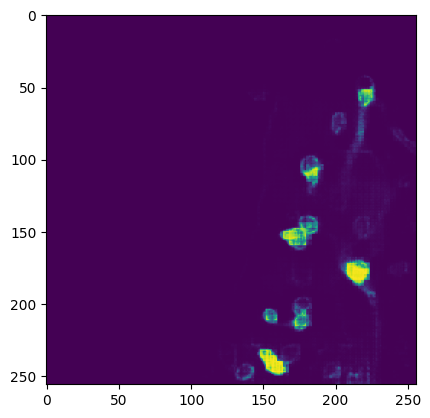

In [ ]:
plt.imshow(preds_dict[(0,2,5)][1])

In [ ]:
[0,2,5] in filtered_mask_patches_list

True

In [ ]:
patches_mask.shape

(11, 11, 256, 256)

In [ ]:

slide_mask=[]
slide_prob=[]
for slide in range(mask_pngs.shape[0]):
  # For every slide
  # Should be 2 slides
  row_mask=[]
  row_prob=[]
  for i in range(patches_mask.shape[0]):
    # For every row
    # SHould be 11
    width_mask=[]
    width_prob=[]
    for j in range(patches_mask.shape[1]):
      # For every column
      # SHould be 11
      if [slide,i,j] in filtered_mask_patches_list:
        width_mask.append(preds_dict[(slide,i,j)][0])
        width_prob.append(preds_dict[(slide,i,j)][1] )
      else:
        width_mask.append(np.zeros((256,256)))
        width_prob.append(np.zeros((256,256)))
    row_mask.append(width_mask)
    row_prob.append(width_prob)

  slide_mask.append(row_mask)
  slide_prob.append(row_prob)


In [ ]:
patch_reconstruction_masks=np.array(slide_mask)
patch_reconstruction_probabilities=np.array(slide_prob)

In [ ]:
patch_reconstruction_masks.shape

(2, 11, 11, 256, 256)

In [ ]:
patch_reconstruction_probabilities.shape

(2, 11, 11, 256, 256)

In [ ]:
from patchify import unpatchify

In [ ]:
patch_reconstruction_masks[0].shape

(11, 11, 256, 256)

In [ ]:
np.unique(patch_reconstruction_masks)

array([0., 1.])

In [ ]:
for idx in range(patch_reconstruction_masks.shape[0]):
  reconstructed_image_array = unpatchify(patch_reconstruction_masks[idx], (2816,2816))
  reconstructed_image = Image.fromarray(reconstructed_image_array)

  # Save or display the reconstructed image
  normalized_image = (255 * (np.array(reconstructed_image) - np.min(np.array(reconstructed_image))) / (np.max(np.array(reconstructed_image)) - np.min(np.array(reconstructed_image)))).astype(np.uint8)

  # Convert to mode 'L' (8-bit grayscale)
  image_L = Image.fromarray(normalized_image, mode='L')

  image_L.save(f'{idx}_resized_mask.png')



In [ ]:
'''

all_img_patches = []
image_patches=[]
mask_patches=[]
for img in range(large_images.shape[0]):
    large_image = large_images[img]
    patches_img = patchify(large_image, (patch_size, patch_size,3), step=step)  #Step=256 for 256 patches means no overlap

    for i in range(patches_img.shape[0]):
        for j in range(patches_img.shape[1]):
            image_patches.append([img,i,j])

            # Indexing the patch
            single_patch_img = patches_img[i,j,:,:]
            all_img_patches.append(single_patch_img)

images_new = np.array(all_img_patches)

#Let us do the same for masks
all_mask_patches = []
for img in range(large_masks.shape[0]):
    large_mask = large_masks[img]
    patches_mask = patchify(large_mask, (patch_size, patch_size), step=step)  #Step=256 for 256 patches means no overlap

    for i in range(patches_mask.shape[0]):
        for j in range(patches_mask.shape[1]):
            mask_patches.append([img,i,j])

            single_patch_mask = patches_mask[i,j,:,:]
            single_patch_mask = (single_patch_mask / 255.).astype(np.uint8)
            all_mask_patches.append(single_patch_mask)

masks_new = np.array(all_mask_patches)